In [2]:
import numpy as np 
import pandas as pd 
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from albumentations import *


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
df_train = pd.read_csv('/content/Sign_Language_Detector-PyTorch/Dataset/sign_mnist_train.csv')
df_test = pd.read_csv('/content/Sign_Language_Detector-PyTorch/Dataset/sign_mnist_train.csv')
print('Train size: ', df_train.shape)
print('Test size: ', df_test.shape)
df_train.head()

Train size:  (27455, 785)
Test size:  (27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [4]:
train_data = df_train.drop('label', axis=1).values
# train_data.shape
# print(train_data.max())
train_mean = train_data.mean()/255.
train_std = train_data.std()/255.
# train_std
print('Mean: ', train_mean)
print('Std: ', train_std)

Mean:  0.6246706203880205
Std:  0.19125296213533416


In [5]:
# Train-Val split
mask = np.random.rand(len(df_train)) < 0.9
df_val = df_train[~mask]
df_train = df_train[mask]
print('Train size: ', df_train.shape)
print('Val size: ', df_val.shape)
print('Test size: ', df_test.shape)
df_train.head()

Train size:  (24725, 785)
Val size:  (2730, 785)
Test size:  (27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


Text(0.5, 1.0, '12')

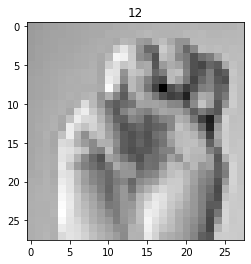

In [6]:
import matplotlib.pyplot as plt
ind = np.random.randint(0, df_train.shape[0]-1)
plt.imshow(df_train.iloc[ind].values[1:].reshape((28,28)), cmap='gray')
plt.title(str(df_train.iloc[ind][0]))

In [29]:
class MNISTDataset(Dataset):
    def __init__(self, df, augmentation=None,transform=None ):
        self.df = df
        self.transform = transform
        self.augmentation=augmentation

    def __len__(self):
        return len(self.df)

    def __getitem__(self, n):
        data = self.df.iloc[n]
        image = data[1:].values.reshape((28,28)).astype(np.uint8)
        label = data[0]

        if self.augmentation:
            image = self.augmentation(image=image)["image"]
        if self.transform:
            image = self.transform(image)
        return (image, label)

In [30]:
batch_size = 128
classes = range(10)
train_transform = transforms.Compose(
                    [
                    transforms.ToPILImage(),
                    transforms.RandomRotation(10),
                    #transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.5, contrast=0.5),
                    transforms.RandomResizedCrop(28, scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[train_mean], std=[train_std]),
                    ])
# don't (really) need the data augmentation in validation
val_transform = transforms.Compose(
                    [
                    transforms.ToPILImage(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[train_mean], std=[train_std]),
                    ])
test_transform = val_transform

train_dataset = MNISTDataset(df_train, 
                             augmentation = Compose([
                                        RandomBrightnessContrast( p=0.5),
                                        ]),
                             transform = train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                batch_size=batch_size,shuffle = True)
val_dataset = MNISTDataset(df_val, transform = val_transform)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                batch_size=batch_size,shuffle = False)

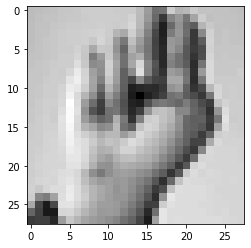

In [31]:
for x in train_loader:
  plt.imshow(x[0][0].reshape(28,28), cmap="gray")
  break

In [33]:
class Network(nn.Module): 
    
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 30, 3)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(30, 40, 3)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(40, 30, 3) 
        self.dropout1 = nn.Dropout2d()
        
        self.fc3 = nn.Linear(30 * 3 * 3, 270) 
        self.fc4 = nn.Linear(270, 26) 
        
        self.softmax = nn.LogSoftmax(dim=1)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x)
                
        x = x.view(-1, 30 * 3 * 3) 
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return self.softmax(x)
    
    
    def test(self, predictions, labels):
        
        self.eval()
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        print("Correct predictions: %5d / %5d (%5f)" % (correct, len(predictions), acc))
        
    
    def evaluate(self, predictions, labels):
                
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        return(acc)

net = Network()
net=net.to(device)

In [34]:
epochs = 30
# batch_size = 64
learning_rate = 0.001

optimizer = optim.Adam(net.parameters(), lr=1e-4)
loss_func = nn.NLLLoss()

In [35]:
loss_log = []
acc_log = []

for e in range(epochs):
    for i in train_loader:
        x_mini, y_mini = i
        x_mini, y_mini=x_mini.to(device), y_mini.to(device)
        
        optimizer.zero_grad()
        net_out = net(x_mini)
        
        loss = loss_func(net_out, y_mini)
        loss.backward()
        optimizer.step()
        
    for j in val_loader:
      x_val, y_val = j
      x_val, y_val=x_val.to(device), y_val.to(device)
      #net_out = net(x_mini)
      #loss_val=loss_func(net_out, y_mini)
      val_acc = net.evaluate(torch.max(net(x_val).data, 1)[1], y_val)
        
        # if i % 1000 == 0:
        #     #pred = net(Variable(test_data_formated))
        #     loss_log.append(loss.item())
        #     acc=net.evaluate(torch.max(net(Variable(test_data_formated[:1000].to(device))).data, 1)[1], 
        #                                 test_labels[:1000])
        #     acc_log.append(acc)
        
    print('epoch: {} - Loss: {:.6f} val_acc: {:.4f} '.format(e + 1, loss.item(), val_acc))

epoch: 1 - Loss: 3.016845 val_acc: 0.2619 
epoch: 2 - Loss: 2.550524 val_acc: 0.4524 
epoch: 3 - Loss: 3.000052 val_acc: 0.5000 
epoch: 4 - Loss: 2.085712 val_acc: 0.6190 
epoch: 5 - Loss: 1.809088 val_acc: 0.6905 
epoch: 6 - Loss: 1.557614 val_acc: 0.6667 
epoch: 7 - Loss: 1.601187 val_acc: 0.6667 
epoch: 8 - Loss: 1.860297 val_acc: 0.7143 
epoch: 9 - Loss: 1.963169 val_acc: 0.6905 
epoch: 10 - Loss: 1.696571 val_acc: 0.7619 
epoch: 11 - Loss: 1.581083 val_acc: 0.6905 
epoch: 12 - Loss: 1.299266 val_acc: 0.7619 
epoch: 13 - Loss: 1.840054 val_acc: 0.6905 
epoch: 14 - Loss: 1.096578 val_acc: 0.7857 
epoch: 15 - Loss: 1.297719 val_acc: 0.7619 
epoch: 16 - Loss: 1.123682 val_acc: 0.7857 
epoch: 17 - Loss: 2.196684 val_acc: 0.7857 
epoch: 18 - Loss: 1.168846 val_acc: 0.8095 
epoch: 19 - Loss: 1.143268 val_acc: 0.7857 
epoch: 20 - Loss: 1.237373 val_acc: 0.7857 
epoch: 21 - Loss: 0.800120 val_acc: 0.8095 
epoch: 22 - Loss: 1.801099 val_acc: 0.7143 
epoch: 23 - Loss: 1.210014 val_acc: 0.761

In [36]:
torch.save(net, 'net_h_aug3.pt')